In [2]:
import dask
dask.config.set({"dataframe.query-planning": False})

import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()

## compute silhouette

In [13]:
import sklearn
# Access the arguments
normalisation = 'lognorm'
segmentation = '10x_0um'
condition = 'breast'
panel = 'breast'
donor = '0OE1'
sample = '0OE1'
k = (segmentation,condition,panel,donor,sample)
name = '/'.join(k)
name_annot = '/'.join(k+('lognorm',))
sample_dir = Path(cfg['std_seurat_analysis_dir']+'/'+name)

sample_pca = sample_dir / f'{normalisation}/preprocessed/pca.parquet'
sample_idx = sample_dir / f'{normalisation}/preprocessed/cells.parquet'
sample_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir']) / f'{name_annot}/reference_based'
max_sample_size = 50_000
metric = 'euclidean'
seed = 0

# read counts
adata = sc.AnnData(pd.read_parquet(sample_pca))
adata.obs_names = pd.read_parquet(sample_idx).iloc[:, 0]

# read annotations
annotations = {}
for reference in (references := sample_annotation_dir.iterdir()):
    for method in (methods := reference.iterdir()):
        for level in (levels := method.iterdir()):
            if (level / "single_cell/labels.parquet").exists():
                annotations[reference.stem, method.stem, level.stem] = (
                    pd.read_parquet(level / "single_cell/labels.parquet").set_index("cell_id").iloc[:, 0]
                )


annotations = pd.DataFrame(annotations).dropna()
annotations.columns = [col for col in annotations.columns]

# add annotations to adata
adata = adata[annotations.index]
adata.obs = adata.obs.join(annotations)

# precompute distances on subsample
sample_size = min(max_sample_size, len(adata))
indices = np.random.default_rng(seed).permutation(len(adata))[:sample_size]
D = sklearn.metrics.pairwise_distances(adata.X[indices], metric=metric)

# compute silhouettes
CT_KEYS = annotations.columns
silhouettes = {}
for CT_KEY in CT_KEYS:
    print(CT_KEY)
    labels = adata.obs[CT_KEY].iloc[indices].values
    silhouettes[CT_KEY] = sklearn.metrics.silhouette_score(D, labels, random_state=seed, metric="precomputed")

# save
silhouettes = pd.Series(silhouettes).reset_index()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


('matched_reference_combo', 'rctd_class_unaware', 'Level2')
('matched_reference_combo', 'rctd_class_unaware', 'Level3')
('matched_reference_combo', 'rctd_class_aware', 'Level4')
('matched_reference_combo', 'rctd_class_aware', 'Level2')
('matched_reference_combo', 'rctd_class_aware', 'Level3')
('external_reference', 'rctd_class_unaware', 'Level3')
('external_reference', 'rctd_class_unaware', 'Level1')
('external_reference', 'rctd_class_aware', 'Level2')
('external_reference', 'rctd_class_aware', 'Level3')


KeyboardInterrupt: 

## panel

In [15]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Access the arguments
panel = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/silhouette/10x_0um/breast/breast/')
silhouette_dir = panel.parents[2]
segmentation_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_segmentation.csv')
reference = 'external_reference'
method = 'rctd_class_aware'
level = 'Level2'
normalisation = 'lognorm'
layer = 'data'

plot_panel = panel.stem
plot_condition = panel.parents[0].stem
palette = pd.read_csv(segmentation_palette,index_col=0)['cols_segmentation']

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "index"]

# read cell type annotation
annot = {}
for segmentation in (segmentations := silhouette_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            if panel.stem != plot_panel:
                continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (segmentation.stem, condition.stem, panel.stem, donor.stem, sample.stem, normalisation)

                    annot[k] = {}
                    annot_file = sample / f"{normalisation}/silhouette_{layer}.parquet"
                    if annot_file.exists():
                        annot[k] = pd.read_parquet(annot_file)
                        

# merge annotations
df_annot = pd.concat(annot)
df_annot = df_annot.reset_index()
df_annot.columns = xenium_levels + df_annot.columns[len(xenium_levels) :].tolist()


df = df_annot.query(f"reference == '{reference}' and method == '{method}' and level == '{level}'")

# plotting params, palette
title = f"condition: {plot_condition}, Panel: {plot_panel}\n Reference: {reference}, Method: {method}, Level: {level}"
hue = "segmentation"
unique_labels = np.unique(df[hue].dropna())
palette = {u: palette[u] for u in unique_labels} 
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, df["sample"].nunique()//2))
g = sns.stripplot(
    data=df, x="silhouette", y="sample", hue=hue, legend=False, palette=palette
)  # , cut=0, width=1,inner='quart')

sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
plt.axvline(0, c="k", linestyle="-", zorder=0, alpha=0.6)

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

## condition violinplot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B: Mann-Whitney-Wilcoxon test two-sided, P_val:1.817e-04 U_stat=0.000e+00
B vs. C: Mann-Whitney-Wilcoxon test two-sided, P_val:1.827e-04 U_stat=0.000e+00
A vs. C: Mann-Whitney-Wilcoxon test two-sided, P_val:1.817e-04 U_stat=0.000e+00


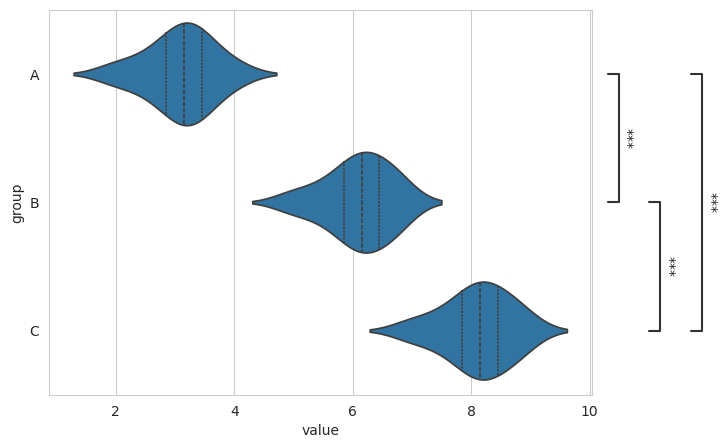

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import pandas as pd

# Sample Data
df = pd.DataFrame({
    "group": ["A"] * 10 + ["B"] * 10 + ["C"] * 10,
    "value": [2, 3, 2.5, 4, 3.5, 2.8, 3.1, 3.2, 3.3, 3.5,
              5, 6, 5.5, 6.2, 5.8, 6.1, 6.5, 6.3, 6.7, 6.8,
              7, 8, 7.5, 8.2, 7.8, 8.1, 8.5, 8.3, 8.7, 8.9]
})

# Create Horizontal Violin Plot
sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))
ax = sns.violinplot(x="value", y="group", data=df, inner="quartile", orient="h")

# Define Statistical Comparisons
pairs = [("A", "B"), ("B", "C"), ("A", "C")]

# Add Statistical Annotations
annotator = Annotator(ax, pairs, data=df, x="value", y="group", orient="h")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_and_annotate()

plt.show()


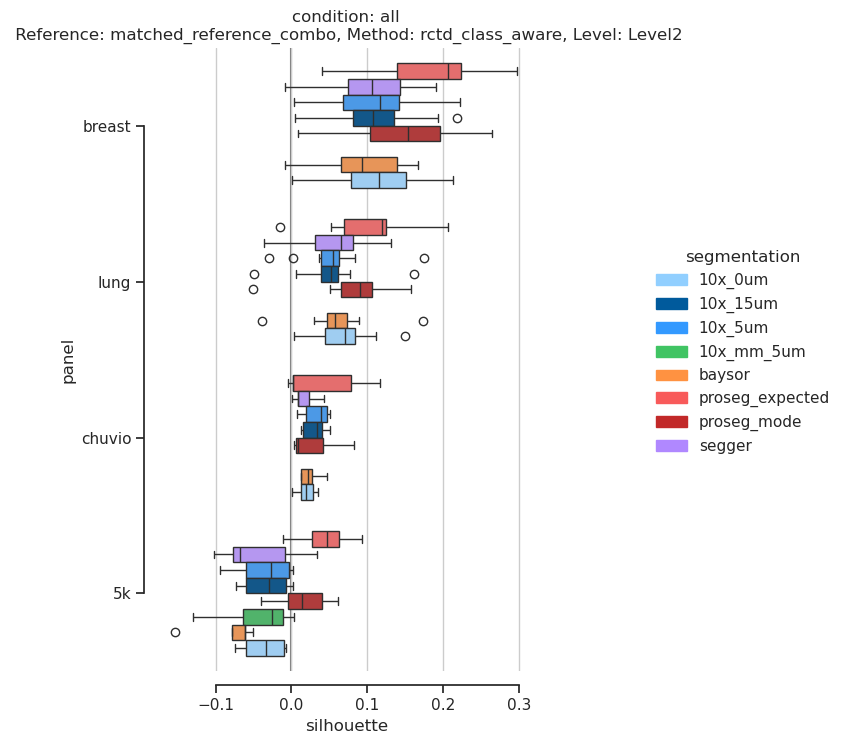

In [30]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Access the arguments
condition = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/silhouette/proseg/breast/')
silhouette_dir = panel.parents[2]
segmentation_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_segmentation.csv')
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2'

plot_condition = 'all'#condition.stem

palette = pd.read_csv(segmentation_palette,index_col=0)['cols_segmentation']

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "index"]

# read cell type annotation
annot = {}
for segmentation in (segmentations := silhouette_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition and plot_condition != "all":
            continue
        for panel in (panels := condition.iterdir()):
            # if panel.stem != plot_panel:
            #     continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    annot[k] = {}
                    annot_file = sample / f"{normalisation}/silhouette_{layer}.parquet"
                    if annot_file.exists():
                        annot[k] = pd.read_parquet(annot_file)

# merge annotations
df_annot = pd.concat(annot)
df_annot = df_annot.reset_index()
df_annot.columns = xenium_levels + df_annot.columns[len(xenium_levels) :].tolist()
# average replicates
df_annot_avg_replicates = df_annot.groupby('donor', as_index=False)['silhouette'].mean()

df = df_annot.query(
    f"reference == '{reference}' and method == '{method}' and level == '{level}'"
)

# plotting params, palette
title = f"condition: {plot_condition}\n Reference: {reference}, Method: {method}, Level: {level}"
hue = "segmentation"
unique_labels = np.unique(df[hue].dropna())
palette = {u: palette[u] for u in unique_labels} 
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, df["panel"].nunique() * 2))
ax=plt.subplot()
g = sns.boxplot(ax=ax,
    data=df, x="silhouette", y="panel", hue=hue, legend=False, palette=palette,
)  # , cut=0, width=1,inner='quart')

sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
plt.axvline(0, c="k", linestyle="-", zorder=0, alpha=0.6)

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])